In [ ]:
import cv2
import numpy as np
from tqdm.notebook import tqdm
from pathlib import Path

from src.libs import utils_graphics
from src.libs.gmm import BayesianColorClassifierLabGMM

%load_ext autoreload
%autoreload 2

## Create the dataset as images from videos

In [ ]:
base_path = Path("./skin-database")
assert base_path.exists()

video_files_gt = list(base_path.glob("*_gt_*.avi"))
video_files = sorted(
    [
        video_file
        for video_file in base_path.glob("*.avi")
        if video_file not in video_files_gt
    ]
)

In [ ]:
videos: list[tuple[Path, Path]] = []
for video_file in video_files:
    vf_gt_wc = f"{video_file.stem}_gt_*{video_file.suffix}"
    try:
        video_file_gt = list(base_path.glob(vf_gt_wc))[0]
        videos.append((video_file, video_file_gt))

    except IndexError:
        print(f"Could not find ground truth for {video_file}")
        continue

for video_file, video_file_gt in videos:
    print(f"Processing {video_file.name} and {video_file_gt.name}")

    video_name = video_file.stem
    frames_path = base_path / Path(f"{video_name}/frames")
    frames_path.mkdir(exist_ok=True, parents=True)
    masks_path = base_path / Path(f"{video_name}/masks")

    if masks_path.exists():
        print(f"Skipping {video_name} as it already exists")
        continue

    masks_path.mkdir(exist_ok=True, parents=True)

    frames_filenames = frames_path / f"{video_name}_%04d.png"
    masks_filenames = masks_path / f"{video_name}_%04d.png"
    !ffmpeg -loglevel quiet -hide_banner -y -i "{video_file}" -vf "fps=4" "{frames_filenames}"
    !ffmpeg -loglevel quiet -hide_banner -y -i "{video_file_gt}" -vf "fps=4" "{masks_filenames}"

In [ ]:
image_paths = [base_path / video_file.stem for video_file in video_files]
images_paths = [
    list((image_path / "frames").glob("*png")) for image_path in image_paths
]

## Create color histograms (one for the queried color and one for the non-colors)

In [ ]:
HIST_SIZE = 32

color_hists = []
for image_paths in tqdm(images_paths):
    for image_file in image_paths:
        image_bgr = cv2.imread(str(image_file))
        # image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        image_lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2LAB)

        mask = cv2.imread(str(image_file).replace("frames", "masks"))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]
        color_hist = cv2.calcHist(
            images=[image_lab],
            channels=[0, 1, 2],
            mask=mask,
            histSize=[HIST_SIZE, HIST_SIZE, HIST_SIZE],
            ranges=[0, 256, 0, 256, 0, 256],
        )

        mask_inv = cv2.bitwise_not(mask)
        non_color_hist = cv2.calcHist(
            images=[image_lab],
            channels=[0, 1, 2],
            mask=mask_inv,
            histSize=[HIST_SIZE, HIST_SIZE, HIST_SIZE],
            ranges=[0, 256, 0, 256, 0, 256],
        )

        color_hists.append((color_hist, non_color_hist))

color_hists_sum: cv2.typing.MatLike | None = None
non_color_hists_sum: cv2.typing.MatLike | None = None

# Sum the histograms
for color_hist, non_color_hist in color_hists:
    if color_hists_sum is None:
        color_hists_sum = color_hist
    else:
        color_hists_sum = cv2.add(
            color_hist,
            color_hists_sum,
        )  # type: ignore

    if non_color_hists_sum is None:
        non_color_hists_sum = non_color_hist
    else:
        non_color_hists_sum = cv2.add(
            non_color_hist,
            non_color_hists_sum,
        )  # type: ignore

## Bayes' Theorem

Bayes' theorem allows you to update the probability of a hypothesis based on new evidence:

$$
P(A \mid B) = \frac{P(B \mid A) \times P(A)}{P(B)}
$$

Where:

- $ P(A \mid B) $: Posterior probability — the probability of hypothesis \( A \) given observed evidence \( B \).
- $ P(B \mid A) $: Likelihood — the probability of observing \( B \) given that \( A \) is true.
- $ P(A) $: Prior probability — the initial probability of hypothesis \( A \) being true.
- $ P(B) $: Marginal probability — the total probability of observing \( B \).

## Color Model Formulation using Bayes' Theorem

Given:

- $ \text{queryColorHistSum} $: Sum of histogram counts for the query color.
- $ \text{nonQueryColorHistSum} $: Sum of histogram counts for non-query colors.
- $ \text{colorHistSum} $: Histogram count for a specific RGB value under the query color.
- $ \text{nonColorHistSum} $: Histogram count for a specific RGB value under non-query colors.
- $ p_{\text{rgbColor}},\ p_{\text{rgbNonColor}} $: Conditional probabilities.
- $ p_{\text{color}},\ p_{\text{nonColor}} $: Prior probabilities.
- $ {P(\text{rgb})} $: The total chance of seeing an RGB value anywhere, computed by weighing its conditional probabilities by the class priors
- $ {P(\text{colorChance} \mid \text{rgb})} $: Posterior probability that a given color belongs to the query color class, after observing the RGB value


### Equations:

$$
P(\text{rgb} \mid \text{queryColor}):
p_{\text{rgbColor}} = \frac{\text{colorHistSum}}{\text{queryColorHistSum}}
$$

$$
P(\text{rgb} \mid \sim\text{queryColor}):
p_{\text{rgbNonColor}} = \frac{\text{nonColorHistSum}}{\text{nonQueryColorHistSum}}
$$

$$
P(\text{queryColor}):
p_{\text{color}} = \frac{\text{queryColorHistSum}}{\text{queryColorHistSum} + \text{nonQueryColorHistSum}}
$$

$$
P(\sim\text{queryColor}):
p_{\text{nonColor}} = 1 - P(\text{queryColor})
$$

$$
P(\text{rgb}) = p_{\text{rgbColor}} \times p_{\text{color}} + p_{\text{rgbNonColor}} \times p_{\text{nonColor}}
$$

$$
P(\text{colorChance} \mid \text{rgb}) = \frac{p_{\text{rgbColor}} \times p_{\text{color}}}{P(\text{rgb})}
$$


In [ ]:
EPS = np.finfo(float).eps
p_color_rgbs = []

color_hist_sum = color_hists_sum
assert color_hist_sum is not None
non_color_hist_sum = non_color_hists_sum
assert non_color_hist_sum is not None

color_hist_sum_s = np.sum(
    color_hist_sum
)  # Value for the total sum of the pixel count of each COLOR bin
non_color_hist_sum_n = np.sum(
    non_color_hist_sum
)  # Value for the total sum of the pixel count of each NON-COLOR bin
print(f"{color_hist_sum_s=}, {non_color_hist_sum_n=}")

# Hit it Bayes!
p_color = color_hist_sum_s / (color_hist_sum_s + non_color_hist_sum_n)  # P(query_color)
p_color_mat = np.asanyarray(p_color, dtype=np.float64)

p_non_color = 1 - p_color  # P(~query_color)
p_non_color_mat = np.asanyarray(p_non_color, dtype=np.float64)
print(f"{p_color=}, {p_non_color=}  {p_color+p_non_color=}")

p_rgb_color = color_hist_sum / color_hist_sum_s  # P(rgb|query_color)
p_rgb_non_color = non_color_hist_sum / non_color_hist_sum_n  # P(rgb|~query_color)
print(f"{np.sum(p_rgb_color)=}, {np.sum(p_rgb_non_color)=}")

p_color_mul = cv2.multiply(p_rgb_color, p_color_mat)
print(np.amin(p_color_mul), np.amax(p_color_mul))
print(f"{p_color_mul.shape=}  {np.sum(p_color_mul)=}")

p_non_color_mul = cv2.multiply(p_rgb_non_color, p_non_color_mat)
print(np.amin(p_non_color_mul), np.amax(p_non_color_mul))
print(f"{p_non_color_mul.shape=}  {np.sum(p_non_color_mul)=}")

p_rgb = (
    p_rgb_color * p_color + p_rgb_non_color * p_non_color
)  # P(rgb) : chance of encountering color rgb

p_rgb[p_rgb == 0] = EPS

print(np.amin(p_rgb), np.amax(p_rgb))
print(f"{p_rgb.shape=}  {np.sum(p_rgb)=}")

# Add the color model to the list
print(f"{p_rgb_color.shape=}")

print(np.amin(p_color_mul), np.amax(p_color_mul))
print(f"{p_color_mul.shape=}  {np.sum(p_color_mul)=}")

p_color_chance = p_rgb_color * p_color / p_rgb  # P(chk_color|rgb)

print(np.amin(p_color_chance), np.amax(p_color_chance))
print(f"{p_color_chance.shape=}  {np.sum(p_color_chance)=}")
p_color_rgbs.append(p_color_chance)

# Calculate the scaling factor for the frame
factor = 1.0 / 256.0 * p_color_rgbs[-1].shape[0]

In [ ]:
THETA = 0.33  # Probability threshold for the color model

idx = 9
test_path = Path(f"mst-e_data/subject_{idx}")
assert test_path.exists()
test_files = list(test_path.glob("*.jpg"))
test_files = sorted(test_files)
test_file = test_files[2]
test_image_bgr = cv2.imread(str(test_file))
test_image_rgb = cv2.cvtColor(test_image_bgr, cv2.COLOR_BGR2RGB)
test_image_rgb = cv2.resize(
    test_image_rgb, None, fx=0.2, fy=0.2, interpolation=cv2.INTER_AREA
)

In [ ]:
test_image_lab = cv2.cvtColor(test_image_rgb, cv2.COLOR_RGB2LAB)

indices = np.floor(test_image_lab * factor).astype(int)
canvas = test_image_lab.copy()
mask = np.zeros_like(test_image_lab, dtype=np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

for pidx, p_color_rgb in enumerate(p_color_rgbs):
    # Fetch probabilities using advanced indexing
    prob = p_color_rgb[indices[:, :, 0], indices[:, :, 1], indices[:, :, 2]]

    # Paint the canvas at these locations
    mask[prob > THETA] = 255

    # Denoise the mask with morphological operations
    mask = cv2.dilate(mask, kernel, None, iterations=5)
    mask = cv2.erode(mask, kernel, None, iterations=5)
    mask = cv2.dilate(mask, kernel, None, iterations=5)

    # Convert the mask to a binary image
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)

    # Apply the mask to the canvas
    canvas = cv2.bitwise_and(test_image_rgb, test_image_rgb, mask=mask)

utils_graphics.displayImArr(canvas)
utils_graphics.displayImArr(test_image_rgb)

## Gaussian Mixture Model

Loading the color classifier
Model loaded from skin-database/color_classifier_gmm.joblib


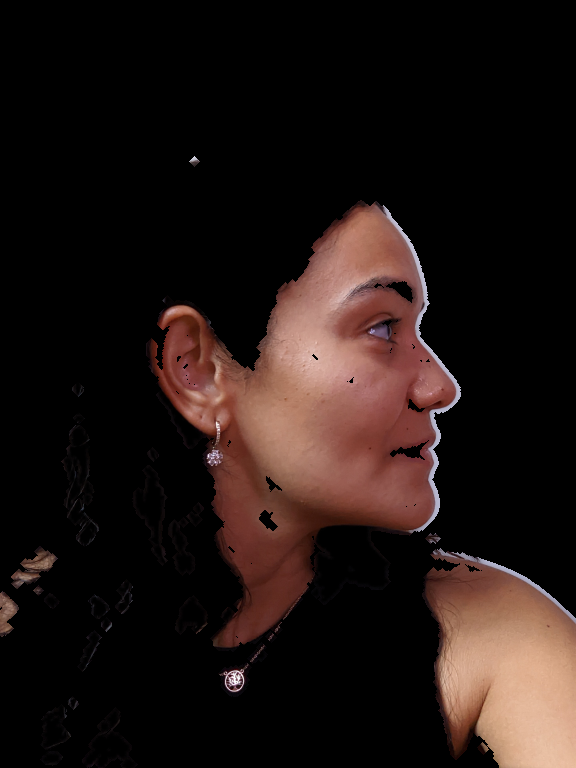

In [45]:
THETA = 0.5  # Probability threshold for the color model

bayesian_classifier = BayesianColorClassifierLabGMM(n_components=16)

if (base_path / "color_classifier_gmm.joblib").exists():
    print("Loading the color classifier")
    bayesian_classifier.load(base_path / "color_classifier_gmm.joblib")

else:
    print("Training the color classifier")
    query_images = []
    non_query_images = []
    for image_paths in tqdm(images_paths):
        for image_file in image_paths[:1]:
            image_bgr = cv2.imread(str(image_file))
            mask = cv2.imread(str(image_file).replace("frames", "masks"))
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]

            mask_inv = cv2.bitwise_not(mask)

            image_mask = cv2.bitwise_and(image_bgr, image_bgr, mask=mask)
            image_non_mask = cv2.bitwise_and(image_bgr, image_bgr, mask=mask_inv)

            query_images.append(image_mask)
            non_query_images.append(image_non_mask)

    bayesian_classifier.fit(query_images, non_query_images)
    bayesian_classifier.save(base_path / "color_classifier_gmm.joblib")
    del query_images
    del non_query_images

test_image_bgr = cv2.imread(str(test_file))
test_image_bgr = cv2.resize(
    test_image_bgr, None, fx=0.2, fy=0.2, interpolation=cv2.INTER_AREA
)
test_image_rgb = cv2.cvtColor(test_image_bgr, cv2.COLOR_BGR2RGB)

prob = bayesian_classifier.predict(test_image_bgr)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
mask = np.zeros_like(test_image_bgr, dtype=np.uint8)
mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
mask[prob > THETA] = 255

# Denoise the mask with morphological operations
mask = cv2.dilate(mask, kernel, None, iterations=5)
mask = cv2.erode(mask, kernel, None, iterations=5)
mask = cv2.dilate(mask, kernel, None, iterations=5)

canvas = cv2.bitwise_and(test_image_rgb, test_image_rgb, mask=mask)

utils_graphics.displayImArr(canvas)